# Project 3 - Sentiment Analysis for E-Commerce Store
### by Azubuogu Peace Udoka

### Table of Content
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#data">Understanding the Dataset</a></li>
<li><a href="#visual">Data Visualisation</a></li>
<li><a href="#feat">Feature Engineering</a></li>
<li><a href="#model">Building the Model</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Background
As a data analyst at Amazon, I have access to a dataset containing product reviews and associated ratings. The task is to build a model that can classify each review as positive, negative, or neutral based on the text content.

In [3]:
# uncomment the code below to install wordcloud
# !pip install wordcloud

In [4]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import re
import string
from scipy import stats
from bs4 import BeautifulSoup
from nltk import word_tokenize 
from wordcloud import WordCloud #ensure wordcloud is installed
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import nltk

%matplotlib inline
#set general style of plots
sns.set(rc = {'figure.figsize':(20,8)}, style="white", font_scale=1.5)

import warnings
warnings.simplefilter("ignore")

In [5]:
# uncomment the code below if error is raised to download punkt
nltk.download('punkt_tab')

[nltk_data] Error loading punkt_tab: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

<a id='data'></a>
## Understanding the Dataset


In [7]:
# load data
data = pd.read_csv('Amazon Product Review.txt')
# view 5 random rows of data
data.sample(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,sentiment
21382,US,26674432,RYGVHBV45B77Y,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,N,nice,"Very fast and reliable, just make sure the col...",2015-01-06,1
29605,US,16083152,R2O49A41Y0AMBQ,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,Best tablet ever. Love it!,2014-11-23,1
1299,US,40241898,RBNZ6XU6GCGCQ,B00IKPW0UA,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,4,0,0,N,N,Four Stars,The Kindle Fire was everything we hoped.,2015-08-09,1
16925,US,44895524,RHORSGKYZVGRX,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,2,2,2,N,Y,False Advertisement-8GB is really under 4.5GB ...,I'm on the phone with Amazon as I write this. ...,2015-02-01,0
24749,US,42308355,R30I5ZVTPT6Q4Z,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,3,0,0,N,Y,What a Kindle!,This is one of Kindle's better products. My w...,2015-01-02,0


In [8]:
# size of dataset
data.shape

(30846, 16)

There are 30846 rows of data and 16 columns

In [10]:
# checking for missing values
data.isnull().sum()

marketplace          0
customer_id          0
review_id            0
product_id           0
product_parent       0
product_title        0
product_category     0
star_rating          0
helpful_votes        0
total_votes          0
vine                 0
verified_purchase    0
review_headline      2
review_body          4
review_date          0
sentiment            0
dtype: int64

There are no missing values.

In [12]:
# checking for duplicates
data.duplicated().sum()

0

There are no dupicates.

In [14]:
# check the datatypes
data.dtypes

marketplace          object
customer_id           int64
review_id            object
product_id           object
product_parent        int64
product_title        object
product_category     object
star_rating           int64
helpful_votes         int64
total_votes           int64
vine                 object
verified_purchase    object
review_headline      object
review_body          object
review_date          object
sentiment             int64
dtype: object

In [15]:
# converting customer_id and product_parent column to string and review_date column to date
data['customer_id'] = data['customer_id'].astype('str')
data['product_parent'] = data['product_parent'].astype('str')
data['review_date'] = pd.to_datetime(data['review_date'])

In [16]:
# fraction of positive and negative reviews
data.sentiment.value_counts()/len(data)

sentiment
1    0.835343
0    0.164657
Name: count, dtype: float64

The sentiment column contains two values.

0 - negative sentiment

1 - positive sentiment

This means, majority of the reviews are positive (83.5343%) and 16.4657% of the reviews are negative.

<a id='visual'></a>
## Data Visualisation
<b>1. WordCloud:</b> To get a general idea of the type of reviews gotten, we will visualise the words using a wordcloud.

In [19]:
# extract only the text from html tags
data['review_body'] = data['review_body'].apply(lambda review: BeautifulSoup(review, 'html.parser').get_text(separator = " ").strip() if isinstance(review, str) else '')
# remove url tags
data['review_body'] = data['review_body'].apply(lambda review: re.sub(r'http\S+', '', review))

In [20]:
# save the pattern for the punctuation in regex
re_punc = re.compile('[%s]' % re.escape(string.punctuation))
# replace the punctuation with nothing --> '' not a whitespace ' ' so that they stand together as a word (wasnt) and not (wasn t)
body = [re_punc.sub(' ', review) for review in data['review_body'].str.lower() if isinstance(review,str)] 
word_body = " ".join([w for w in body])

In [21]:
# save the pattern for the punctuation in regex
re_punc = re.compile('[%s]' % re.escape(string.punctuation))
# replace the punctuation with nothing --> '' not a whitespace ' ' so that they stand together as a word (wasnt) and not (wasn t)
head = [re_punc.sub(' ', review) for review in data['review_headline'].str.lower() if isinstance(review,str)] 
word_head = " ".join([w for w in head])

In [22]:
# define stopwords 
my_stop_words = ENGLISH_STOP_WORDS.union(['Amazon','product','Kindle','br','star','stars', 'tablet', 'book','app','use', 'screen','device','battery', 'apps','books','just',"I'm","don't"])

In [23]:
# create word cloud for the review body
word_cloud_1 = WordCloud(stopwords = my_stop_words, collocations = False, background_color = 'white').generate(word_body)
# create word cloud for the review headline
word_cloud_2 = WordCloud(stopwords = my_stop_words, collocations = False, background_color = 'white').generate(word_head)

### Plotting Review Body WordCloud

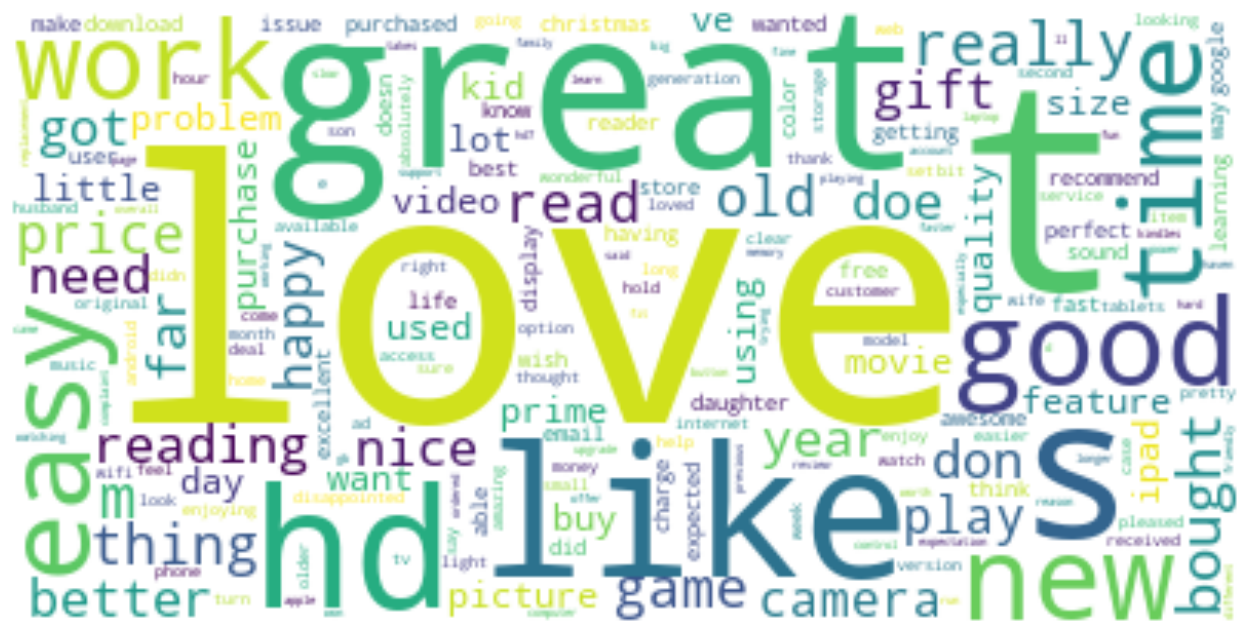

In [25]:
plt.imshow(word_cloud_1, interpolation='bilinear')
plt.axis("off")
plt.show()

### Plotting Review Headline WordCloud

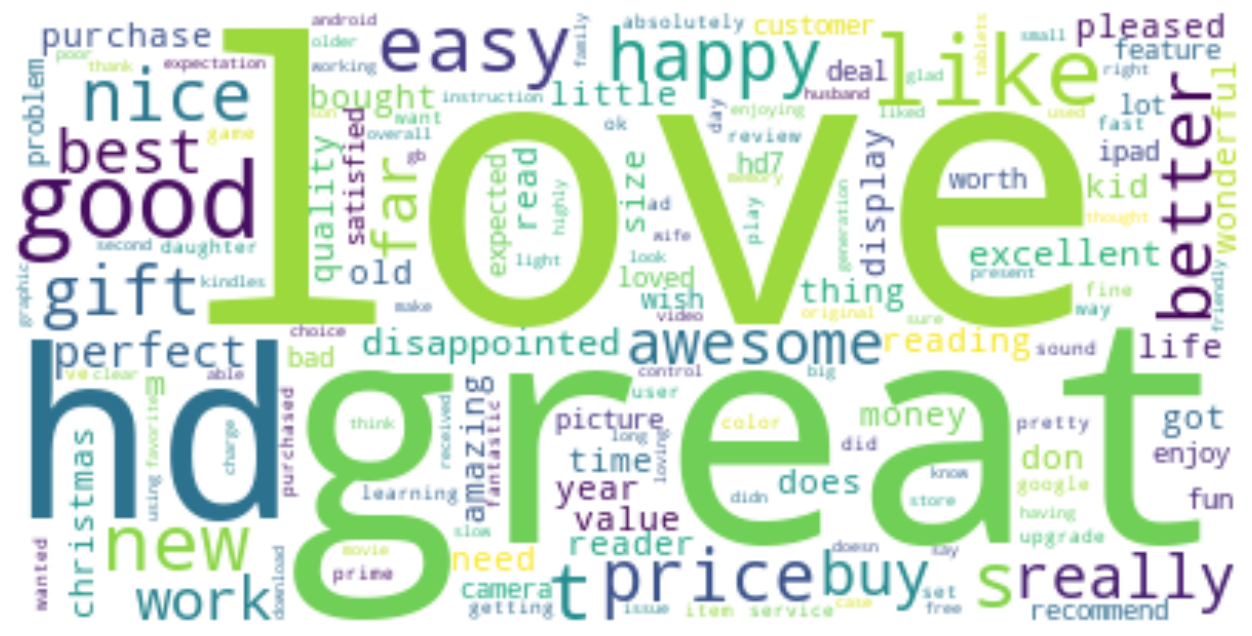

In [27]:
plt.imshow(word_cloud_2, interpolation='bilinear')
plt.axis("off")
plt.show()

From the wordcloud, we can agree to the percentages earlier found that most of the reviews are positive.

<b>2. Visualising Star Rating </b>

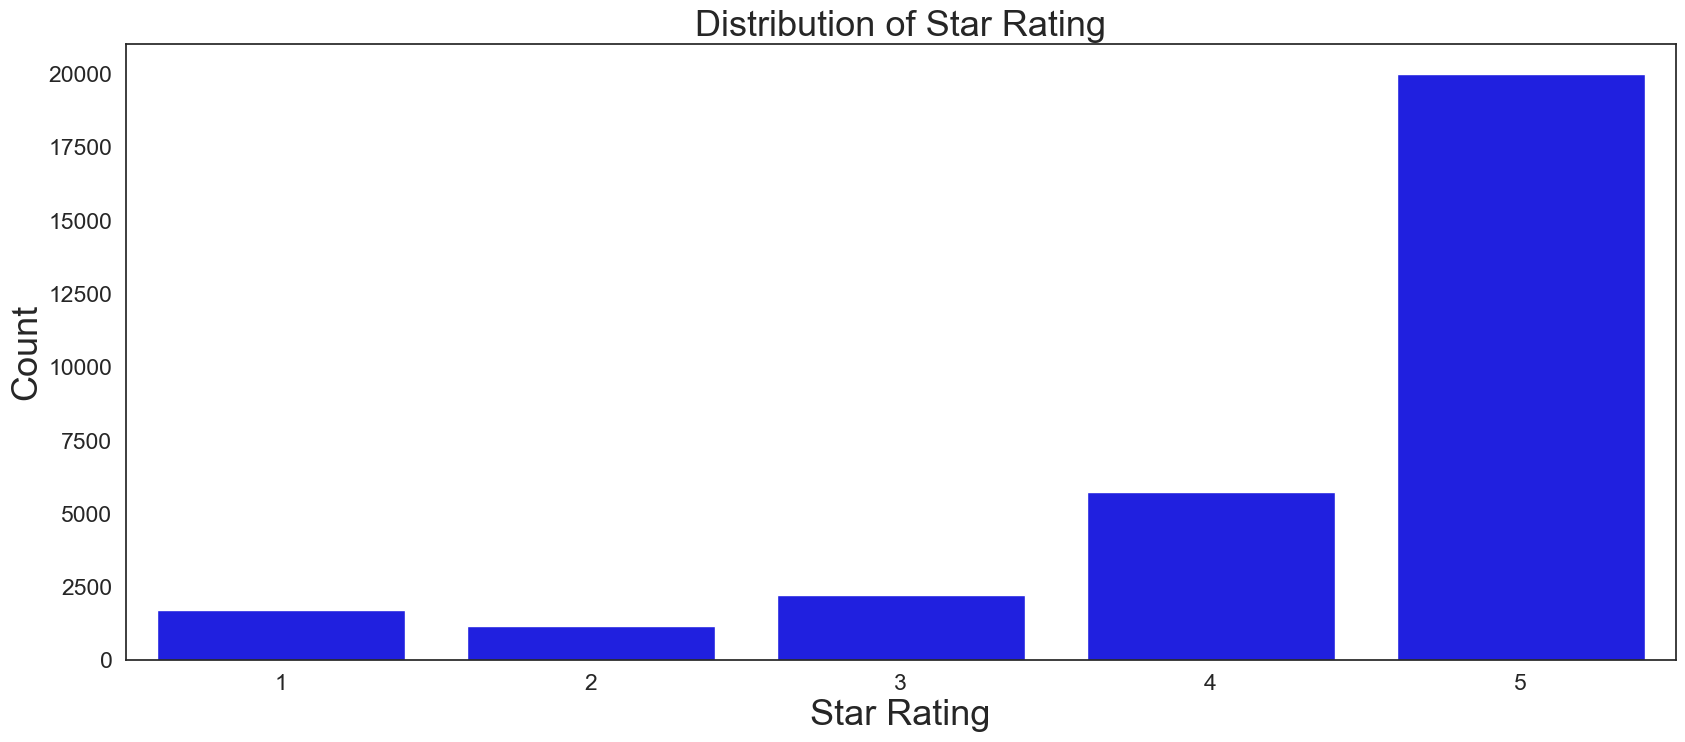

In [30]:
# plotting star ratings
sns.countplot(data = data, x = 'star_rating', color = 'blue')
plt.xlabel("Star Rating", fontsize=26);
plt.ylabel("Count", fontsize=26);
plt.title("Distribution of Star Rating", fontsize=26);
plt.show()

<b>3. Correlation Between Ratings and Helpful Votes :</b>

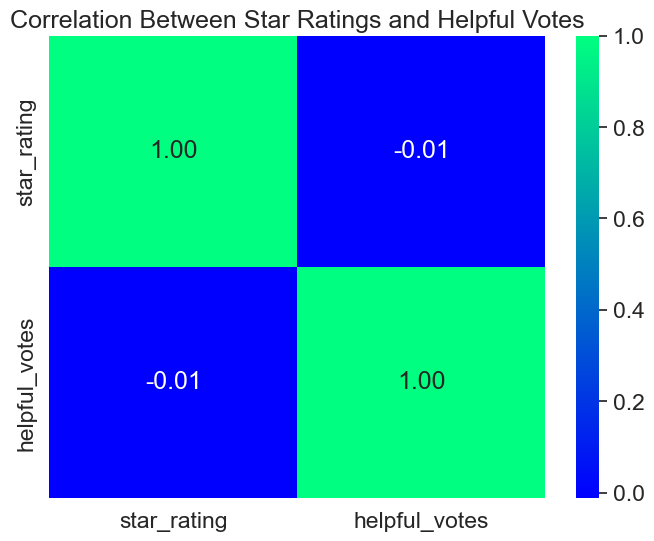

In [32]:
# Calculate the correlation matrix
correlation_matrix = data[['star_rating', 'helpful_votes']].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))  # Set the figure size
sns.heatmap(correlation_matrix, annot=True, cmap='winter', fmt=".2f")
plt.title('Correlation Between Star Ratings and Helpful Votes')
plt.show()

There is no meaningful relationship between star_rating and helpful_votes.

<b>4. Analyzing Review Length :</b>

In [35]:
# Calculate review length
data['review_length'] = data['review_body'].apply(lambda review: len(str(review).split()))

data['review_length'].describe()

count    30846.000000
mean        33.336057
std         62.261423
min          0.000000
25%          6.000000
50%         16.000000
75%         37.000000
max       2338.000000
Name: review_length, dtype: float64

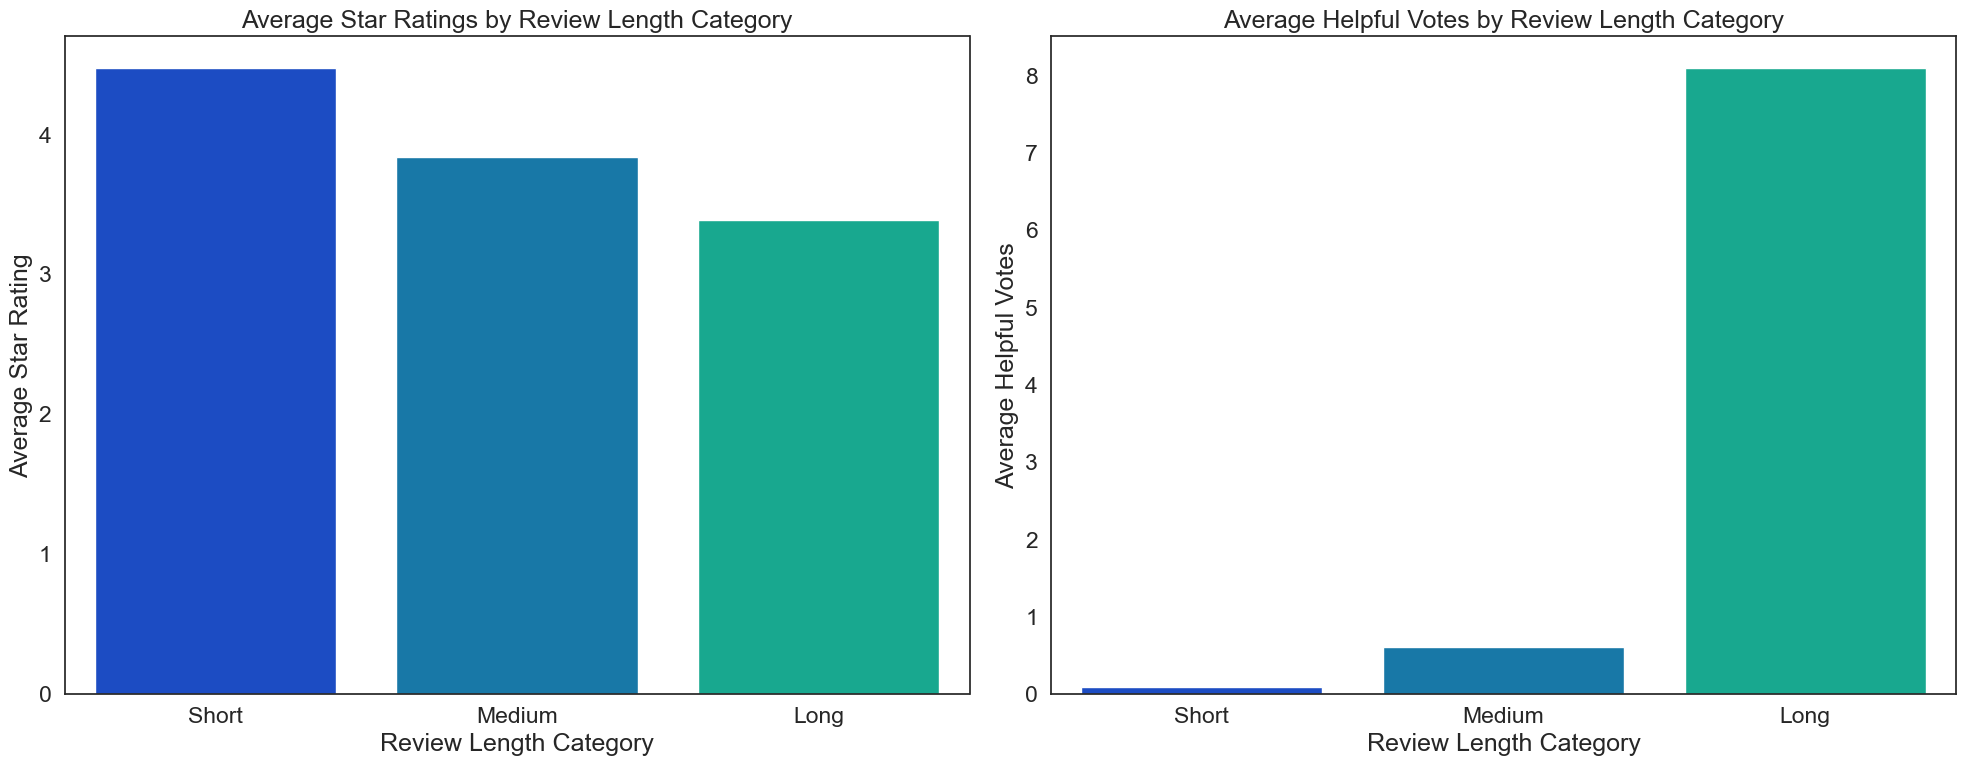

In [36]:
# Create bins for review lengths
bins = [0, 50, 100, float('inf')]  # Define bins for short, medium, long reviews
labels = ['Short', 'Medium', 'Long']
data['length_category'] = pd.cut(data['review_length'], bins=bins, labels=labels)

# Aggregate data by review length category
average_ratings = data.groupby('length_category')['star_rating'].mean().reset_index()
average_helpfulness = data.groupby('length_category')['helpful_votes'].mean().reset_index()

# Bar plot for Average Star Ratings by Review Length Category
plt.subplot(1, 2, 1)
sns.barplot(x='length_category', y='star_rating', data=average_ratings, palette = 'winter')
plt.title('Average Star Ratings by Review Length Category')
plt.xlabel('Review Length Category')
plt.ylabel('Average Star Rating')

# Bar plot for Average Helpful Votes by Review Length Category
plt.subplot(1, 2, 2)
sns.barplot(x='length_category', y='helpful_votes', data=average_helpfulness, palette = 'winter')
plt.title('Average Helpful Votes by Review Length Category')
plt.xlabel('Review Length Category')
plt.ylabel('Average Helpful Votes')

plt.tight_layout()
plt.show()


From the above, it can be observed that shorter reviews tend to have a higher average rating and longer reviews are more associated with higher helpful votes.

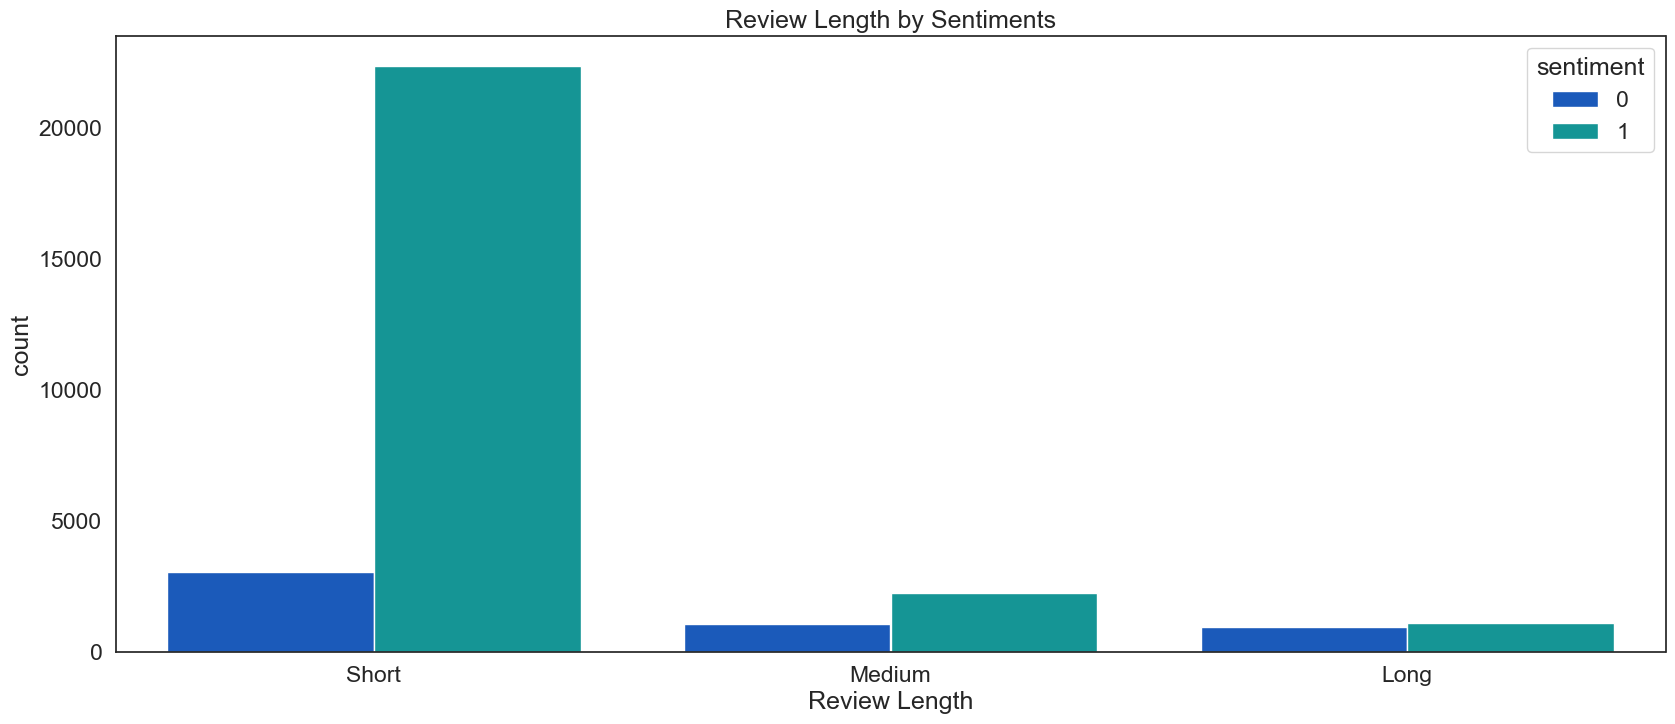

In [38]:
# review length by sentiment
sns.countplot(x='length_category', hue='sentiment', data=data, palette = 'winter')
plt.xlabel('Review Length')
plt.title('Review Length by Sentiments')
plt.show()

This reinforces the above that shorter reviews are more likely to be positive with higher ratings.

<b> Time Series Analysis of Reviews: </b>

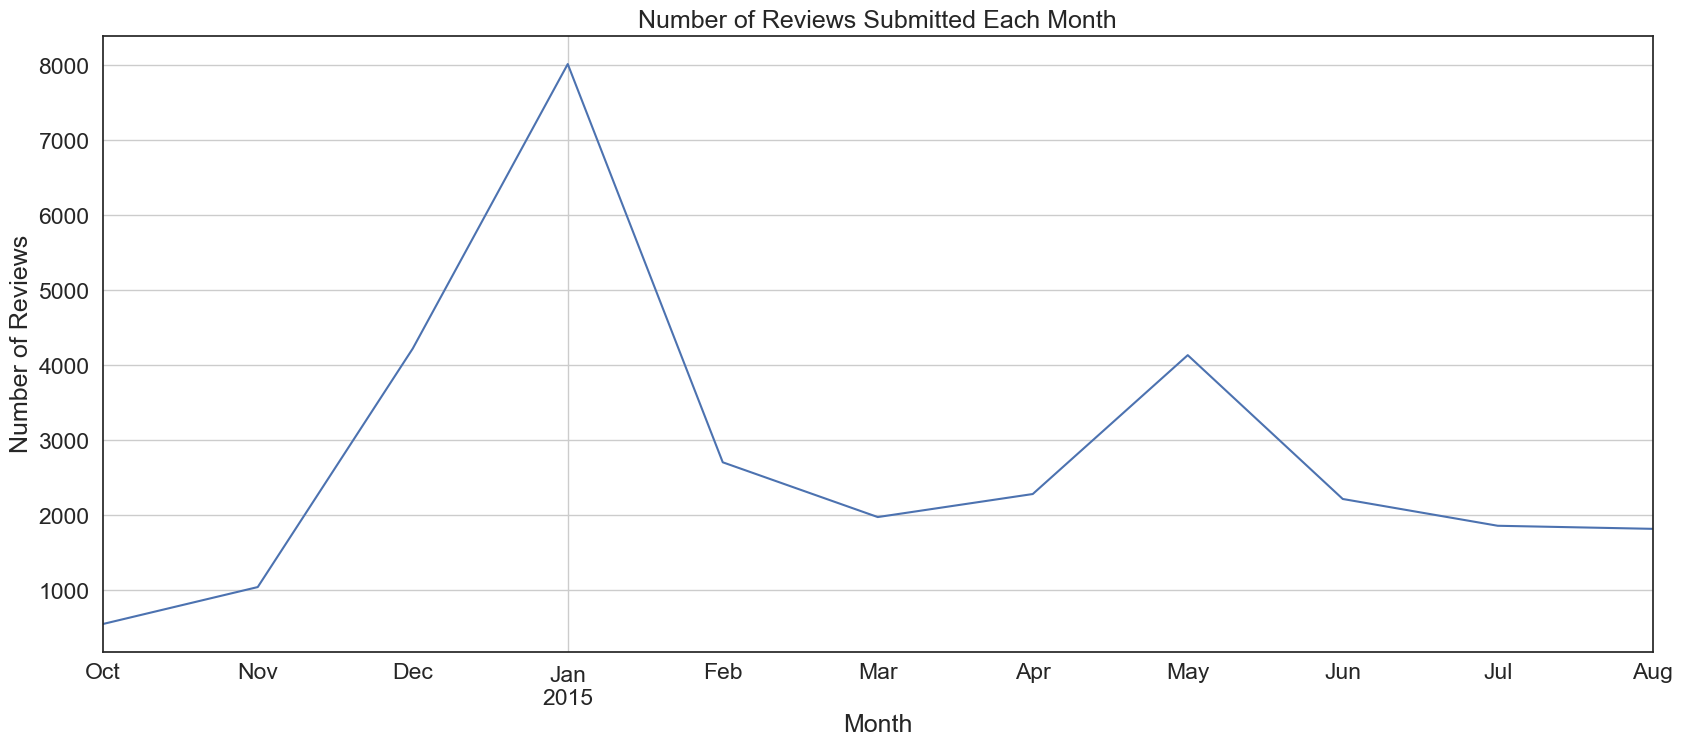

In [41]:
# group data by month and count
monthly_reviews = data.resample('M', on='review_date').size()

# Visualize trends
monthly_reviews.plot()
plt.title('Number of Reviews Submitted Each Month')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.grid()
plt.show()

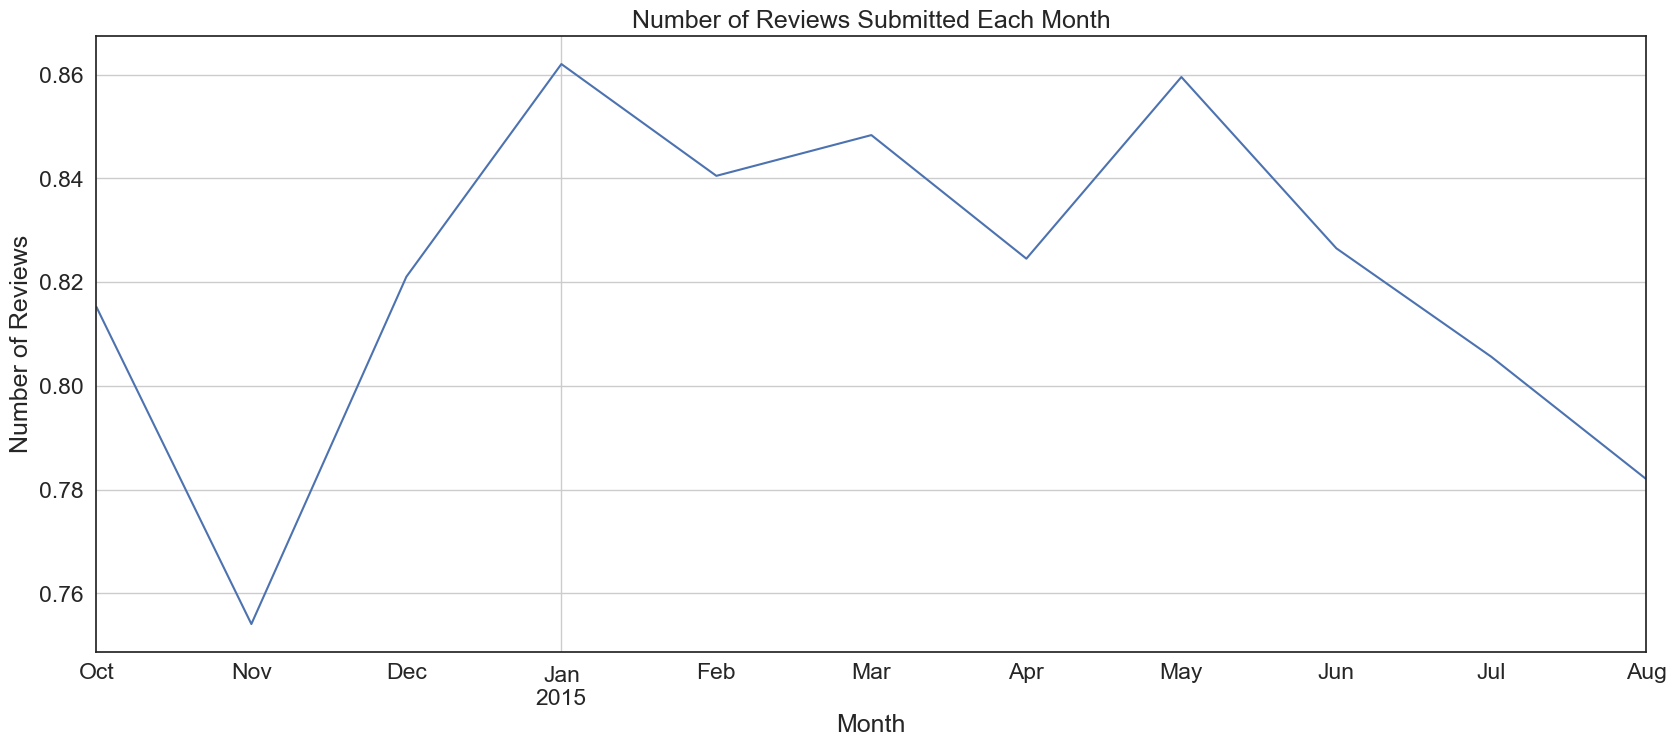

In [42]:
# group data by month and count
monthly_reviews = data.resample('M', on='review_date')['sentiment'].mean()

# Visualize trends
monthly_reviews.plot()
plt.title('Number of Reviews Submitted Each Month')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.grid()
plt.show()

Notice that the number of reviews was highest in January 2015. 

Further assessment shows that the dataset contains just one product being sold in the US so product analysis can't be done. Also, the reviews are from unique customers, hence customer behaviour analysis and segmentation can't be done.

## Data Preprocessing

To build a model, the data has to be transformed to numeric features by using a vectorizer.

In [197]:
# define the vectorizer and specify the arguments, ngrams (1,3) considers unigram - one word, bigram - two consecutive words, trigram - three words 
vect = TfidfVectorizer(ngram_range=(1, 3), max_features=500, token_pattern=r'\b[^\d\W][^\d\W]+\b', stop_words=list(my_stop_words)).fit(body)

# Transform the vectorizer
num_txt = vect.transform(body).toarray()
 

<a id='model'></a>
## Building the Model

This is a binary classification problem.


In [143]:
# define target and features
y = data.sentiment
X = num_txt

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [165]:
# Build model and calculate the accuracy

def build(model):
    model = model().fit(X_train, y_train)

    return model

def result(model):
    
    # predicting and calculating accuracy
    predict = model.predict(X_test)
    print(predict[0])
    # classification report
    print(classification_report(y_test,predict))

    # plot confusion matrix
    cm = confusion_matrix(y_test,predict)
    ConfusionMatrixDisplay(cm).plot()
    plt.show()

In [203]:
# logistic regression model
logreg = LogisticRegression().fit(X_train, y_train)

1
              precision    recall  f1-score   support

           0       0.74      0.54      0.63      1018
           1       0.91      0.96      0.94      5152

    accuracy                           0.89      6170
   macro avg       0.83      0.75      0.78      6170
weighted avg       0.89      0.89      0.89      6170



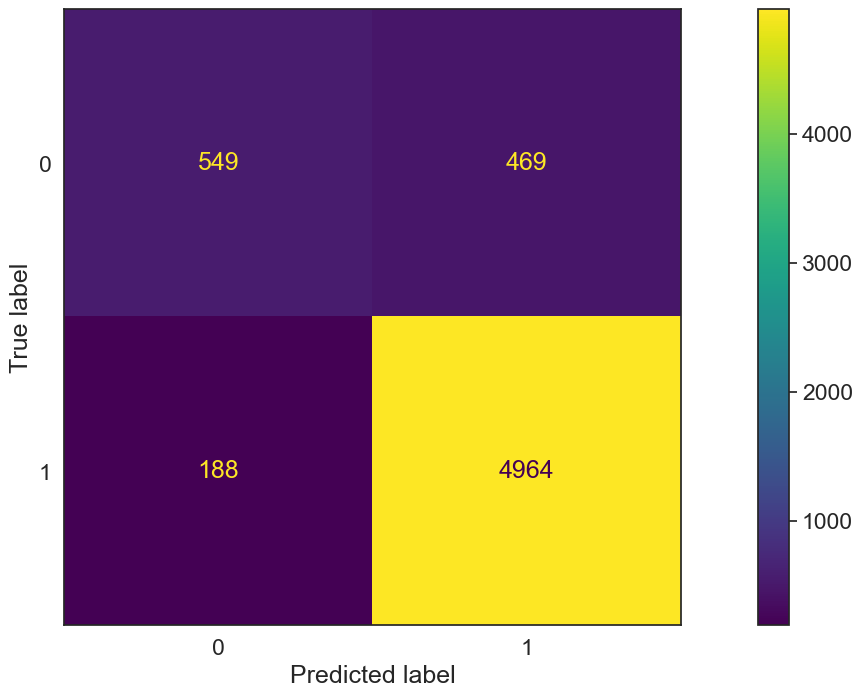

In [205]:
result(logreg)

              precision    recall  f1-score   support

           0       0.70      0.50      0.59      1018
           1       0.91      0.96      0.93      5152

    accuracy                           0.88      6170
   macro avg       0.80      0.73      0.76      6170
weighted avg       0.87      0.88      0.87      6170



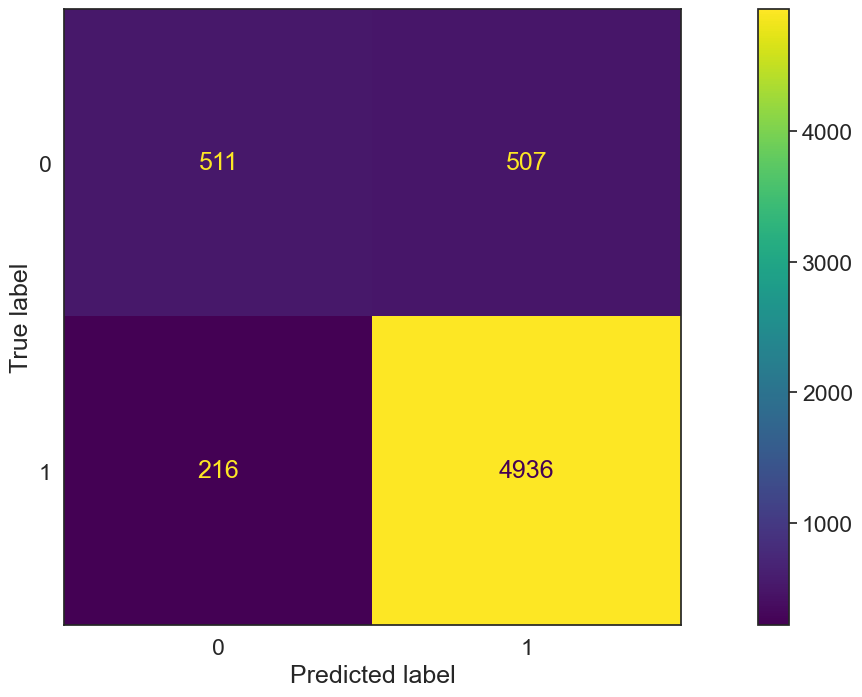

In [52]:
# RandomForestClassifier model
build(RandomForestClassifier)

              precision    recall  f1-score   support

           0       0.41      0.83      0.55      1018
           1       0.96      0.77      0.85      5152

    accuracy                           0.78      6170
   macro avg       0.69      0.80      0.70      6170
weighted avg       0.87      0.78      0.80      6170



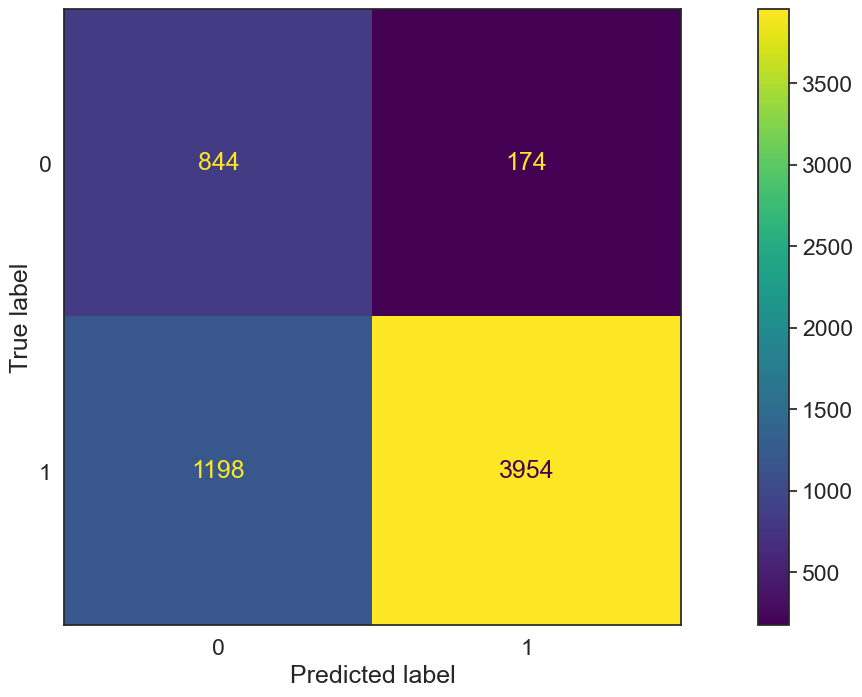

In [53]:
#build GaussianNB model
build(GaussianNB)

              precision    recall  f1-score   support

           0       0.54      0.50      0.52      1018
           1       0.90      0.92      0.91      5152

    accuracy                           0.85      6170
   macro avg       0.72      0.71      0.71      6170
weighted avg       0.84      0.85      0.84      6170



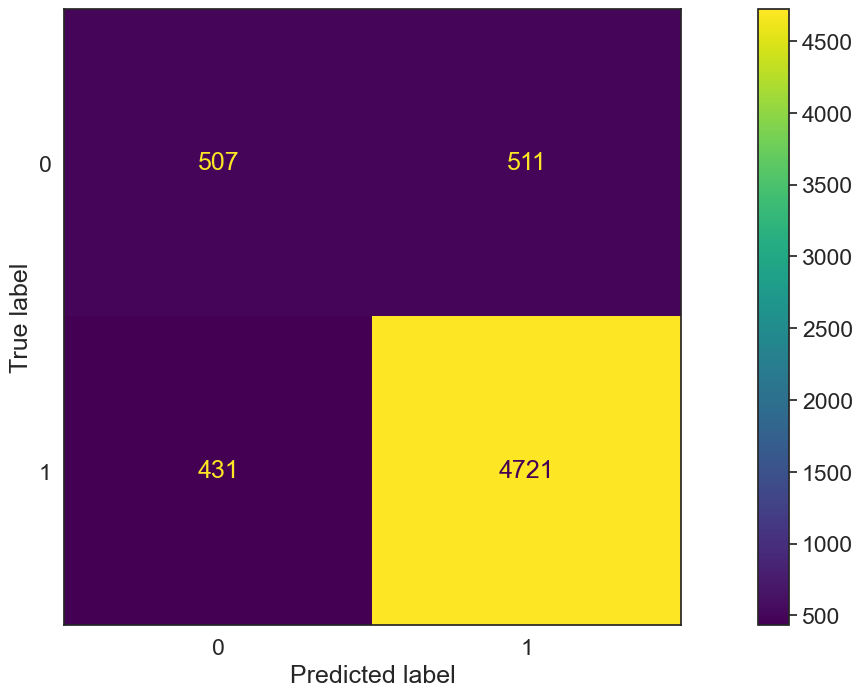

In [54]:
#build DecisionTreeClassifier model
build(DecisionTreeClassifier)

The Logistics Regression Model has the highest accuracy. Saving the best model.

In [207]:
#saving the best model

joblib.dump(logreg, 'LR_model.pkl')

['LR_model.pkl']

In [209]:
#saving the vectorizer

joblib.dump(vect, 'TfIdf_vect.pkl')

['TfIdf_vect.pkl']

In [199]:
text = ["I am happy"]
logreg.predict(vect.transform(text).toarray())[0]

1